# Семинар по Detection, Part 2: RetinaNet
#### Курс по компьютерному зрению школы MADE.

Useful links:
- coco dataset: http://cocodataset.org/#home
- based on code: https://github.com/yhenon/pytorch-retinanet
- paper Feature Pyramid Networks: https://arxiv.org/pdf/1612.03144.pdf
- paper RetinaNet: https://arxiv.org/pdf/1708.02002.pdf
- paper EfficientDet: https://arxiv.org/pdf/1911.09070.pdf

## RetinaNet
FPN + Focal loss

## Feature Pyramid Network

In [ ]:
# !wget https://www.dropbox.com/s/gle8bz1mdb0j8wk/resnet18-5c106cde.pth

In [1]:
import os, sys, cv2
import torch
import numpy as np
from IPython.display import Image
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
# device = torch.cuda.is_available() and 'cuda' or 'cpu'
device = 'cpu'

## Dataset - загрузка данных

In [3]:
from torchvision import transforms
from torch.utils.data import DataLoader
from retinanet.dataloader import CocoDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter, \
    Normalizer
# coco_path = 'data/COCO'
# # deepdive: what's label ?
# dataset_train = CocoDataset(coco_path, set_name='train2017',
#                                     transform=transforms.Compose([Normalizer(), Augmenter(), Resizer()]))
# dataset_val = CocoDataset(coco_path, set_name='val2017',
#                                   transform=transforms.Compose([Normalizer(), Resizer()]))

# train_imgs, val_imgs = dataset_train.image_ids, dataset_val.image_ids # for hacks

In [9]:
# sampler = AspectRatioBasedSampler(dataset_train, batch_size=2, drop_last=False) # deepdive
# dataloader_train = DataLoader(dataset_train, num_workers=3, collate_fn=collater, batch_sampler=sampler)
# # ! collater for padding images

# sampler_val = AspectRatioBasedSampler(dataset_val, batch_size=1, drop_last=False)
# dataloader_val = DataLoader(dataset_val, num_workers=3, collate_fn=collater, batch_sampler=sampler_val)

# print(len(dataloader_train), len(dataloader_val)) 

# for i, batch in enumerate(dataloader_train):
#      img, annot = batch['img'], batch['annot']
#      print ('img shape', img.shape)
#      print ('annot shape', annot.shape)
#      break

In [8]:
with open('data/sample_batch.json', 'rb') as rf:
    batch = torch.load(rf)
    img, annot = batch['img'], batch['annot']
    
print(img.shape) # batch x channel x h x w
print(annot.shape) # batch x number of bboxes x (4 points + class label)

torch.Size([2, 3, 640, 832])
torch.Size([2, 40, 5])


## Model = Backbone + FPN + (SubNets + Anchors)

## Anchors

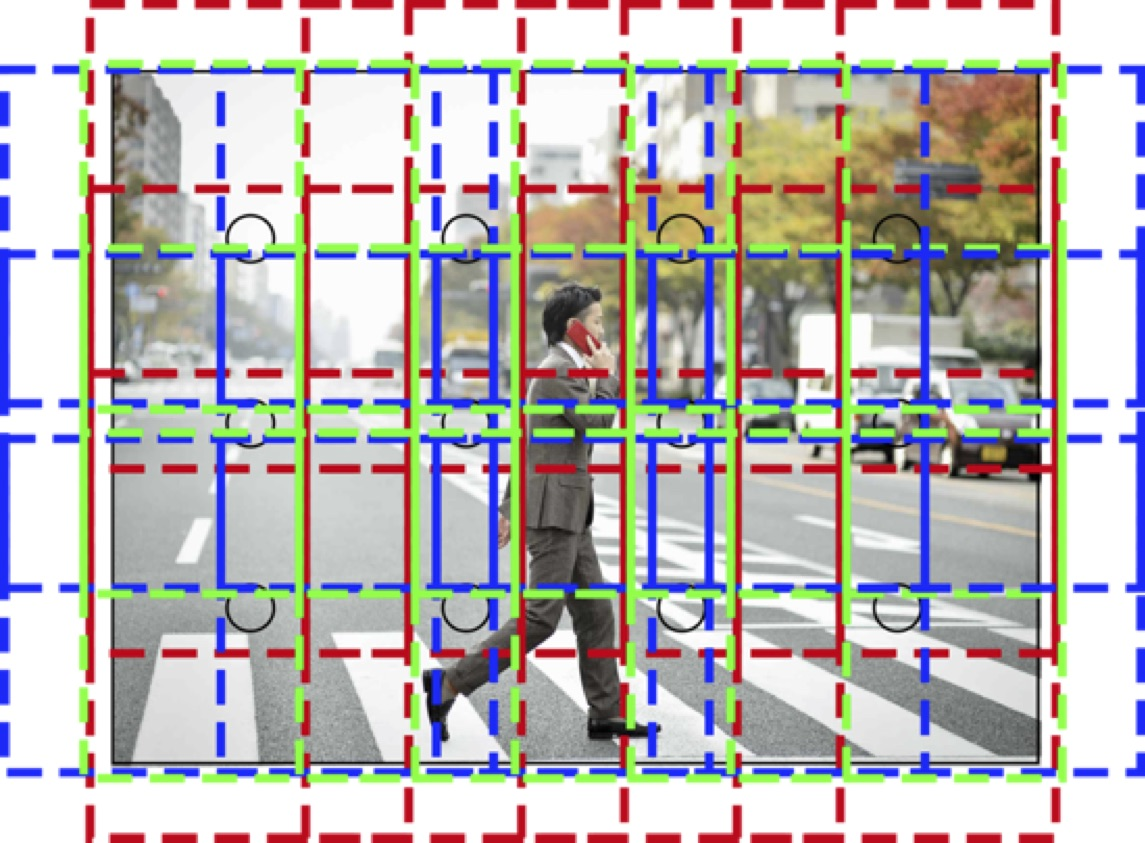

In [4]:
# Image(filename='images/overall.png')
Image(filename='images/acnhor_1.jpg')

In [5]:
import torch.nn as nn
from retinanet.anchors import generate_anchors, shift 
class Anchors(nn.Module):
    def __init__(self, pyramid_levels=None, strides=None, sizes=None, ratios=None, scales=None, device=None):
        super(Anchors, self).__init__()

        if pyramid_levels is None:
            self.pyramid_levels = [3, 4, 5, 6, 7]
        if strides is None:
            self.strides = [2 ** x for x in self.pyramid_levels]
        if sizes is None:
            self.sizes = [2 ** (x + 2) for x in self.pyramid_levels]
        if ratios is None:
            self.ratios = np.array([0.5, 1, 2])
        if scales is None:
            self.scales = np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

        if device is None:
            device = torch.cuda.is_available() and 'cuda' or 'cpu'
        self.device = device

    def forward(self, image):
        
        image_shape = image.shape[2:] # trim batch and channel
        image_shape = np.array(image_shape)
        image_shapes = [(image_shape + 2 ** x - 1) // (2 ** x) for x in self.pyramid_levels]

        # compute anchors over all pyramid levels
        all_anchors = np.zeros((0, 4)).astype(np.float32)

        for idx, p in enumerate(self.pyramid_levels):
            # generate 9 anchors
            anchors         = generate_anchors(base_size=self.sizes[idx], ratios=self.ratios, scales=self.scales)
            # grid all over the shape with stride
            shifted_anchors = shift(image_shapes[idx], self.strides[idx], anchors)
            print(self.strides[idx], shifted_anchors.shape)
            all_anchors     = np.append(all_anchors, shifted_anchors, axis=0)

        all_anchors = np.expand_dims(all_anchors, axis=0)

        return torch.from_numpy(all_anchors.astype(np.float32)).to(self.device)

anchors = Anchors(device=device)
print('strides', anchors.strides) # '-> areas from 32^2 to 512^2'
print('sizes', anchors.sizes) # areas

strides [8, 16, 32, 64, 128]
sizes [32, 64, 128, 256, 512]


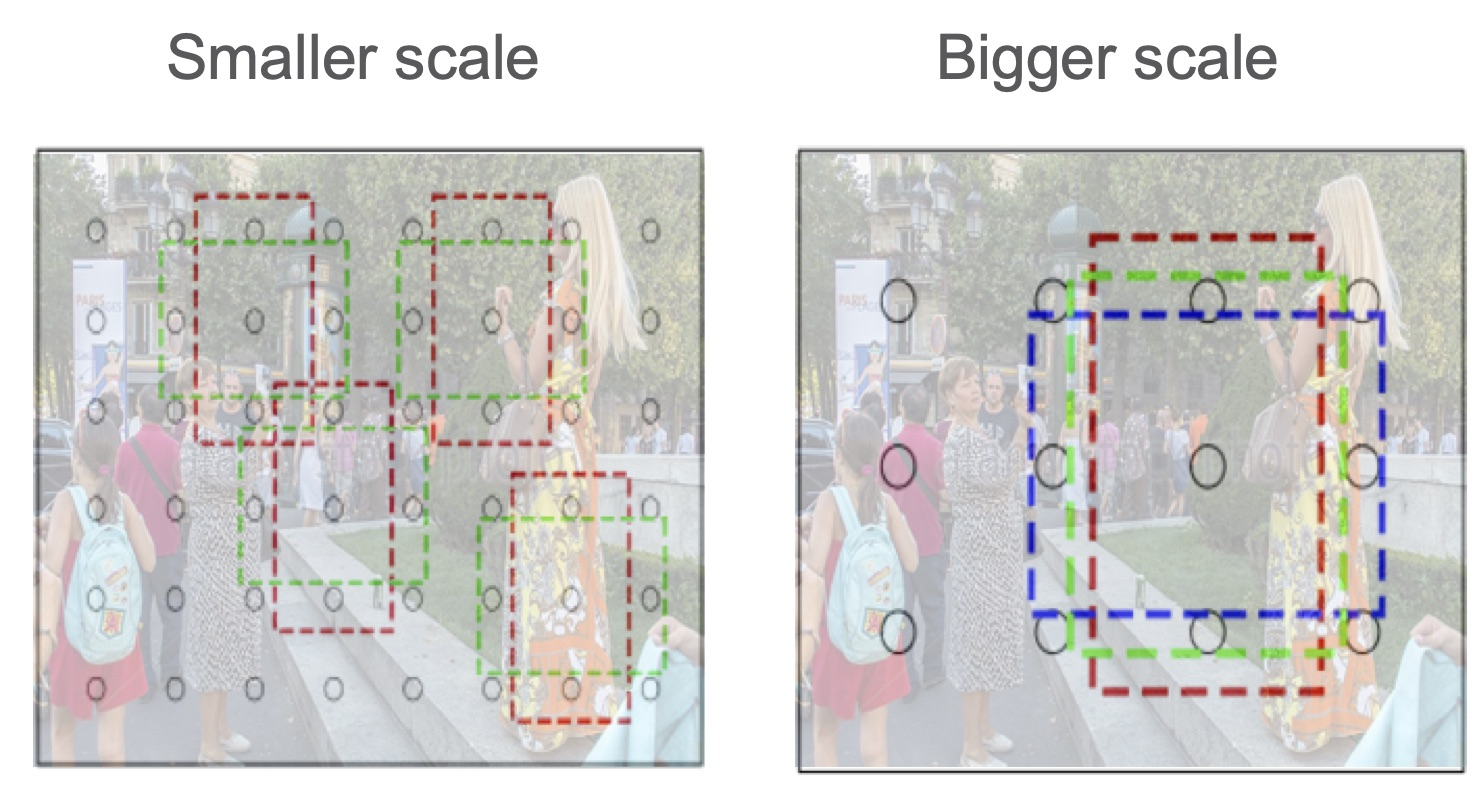

In [6]:
Image(filename='images/anchor_2.jpg')
# Вопрос: почему не сделать разного размера anchor boxes и
# предсказывать на одном разрешении ?

In [7]:
print('ratios', list(anchors.ratios), "at each pyramid level three aspect ratios {1:2, 1:1, 2:1}") # 
print('scales', list(anchors.scales)) # For denser scale coverage than in [20], at each level we add anchors of sizes {2} of the original set of 3 aspect ratio anchors.

ratios [0.5, 1.0, 2.0] at each pyramid level three aspect ratios {1:2, 1:1, 2:1}
scales [1.0, 1.2599210498948732, 1.5874010519681994]


In [8]:
image = np.zeros((0,3,500,800))
anc = anchors.forward(image)
print('Anchors', anc.shape, anc.device)
# print(anc[0,-1,:])

8 (56700, 4)
16 (14400, 4)
32 (3600, 4)
64 (936, 4)
128 (252, 4)
Anchors torch.Size([1, 75888, 4]) cpu


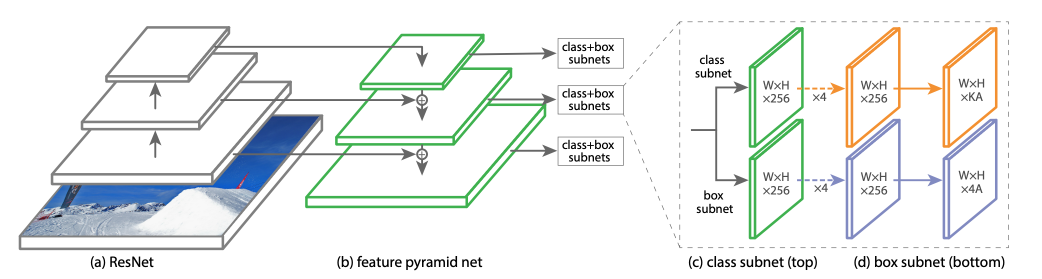

In [9]:
Image(filename='images/overall.png')
#FPN


In [16]:
# Backbone
import torch.nn as nn
from retinanet.utils import BasicBlock, Bottleneck # deepdive

class ResNet(nn.Module):

    def __init__(self, num_classes, block, layers):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, inputs):
        if self.training:
            img_batch, annotations = inputs
        else:
            img_batch = inputs
        
        # To write: everything, returns output of layer2, 3, 4 as features
        x = self.conv1(img_batch)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        
        return (x2,x3,x4)

resnet18_layers = [2, 2, 2, 2]      
num_classes = 80 # dataset_train.num_classes()
resnet18 = ResNet(num_classes=num_classes, block=BasicBlock, layers=resnet18_layers).to(device)

x2,x3,x4 = resnet18((img, annot))
print ('x2', x2.size())
print ('x3', x3.size())
print ('x4', x4.size())


x2 torch.Size([2, 128, 80, 104])
x3 torch.Size([2, 256, 40, 52])
x4 torch.Size([2, 512, 20, 26])


In [17]:
# FPN : make pyramid
class PyramidFeatures(nn.Module):
    def __init__(self, C3_size, C4_size, C5_size, feature_size=256):
        super(PyramidFeatures, self).__init__()

        # upsample C5 to get P5 from the FPN paper
        self.P5_1 = nn.Conv2d(C5_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P5_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P5_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        # add P5 elementwise to C4
        self.P4_1 = nn.Conv2d(C4_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P4_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P4_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        # add P4 elementwise to C3
        self.P3_1 = nn.Conv2d(C3_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P3_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        # "P6 is obtained via a 3x3 stride-2 conv on C5"
        self.P6 = nn.Conv2d(C5_size, feature_size, kernel_size=3, stride=2, padding=1)

        # "P7 is computed by applying ReLU followed by a 3x3 stride-2 conv on P6"
        self.P7_1 = nn.ReLU()
        self.P7_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=2, padding=1)

    def forward(self, inputs):
        C3, C4, C5 = inputs

        P5_x = self.P5_1(C5)
        P5_upsampled_x = self.P5_upsampled(P5_x)
        P5_x = self.P5_2(P5_x)

        P4_x = self.P4_1(C4)
        P4_x = P5_upsampled_x + P4_x
        P4_upsampled_x = self.P4_upsampled(P4_x)
        P4_x = self.P4_2(P4_x)

        # to write: get P3_x
        # прокидываем connection от C3
        # апсемплим P4 + P3
        # P3_x свертываем еще раз
        P3_x = self.P3_1(C3)
        P3_x = P4_upsampled_x + P3_x
        P3_x = self.P3_2(P3_x)        

        P6_x = self.P6(C5)

        P7_x = self.P7_1(P6_x)
        P7_x = self.P7_2(P7_x)

        return [P3_x, P4_x, P5_x, P6_x, P7_x]


fpn_sizes = [resnet18.layer2[resnet18_layers[1] - 1].conv2.out_channels, resnet18.layer3[resnet18_layers[2] - 1].conv2.out_channels,
                         resnet18.layer4[resnet18_layers[3] - 1].conv2.out_channels]
fpn = PyramidFeatures(*fpn_sizes).to(device)

print('x2,x3,x4 shapes:', x2.shape, x3.shape, x4.shape)
features = fpn([x2, x3, x4])

for feature in features:
    print(feature.shape)

x2,x3,x4 shapes: torch.Size([2, 128, 80, 104]) torch.Size([2, 256, 40, 52]) torch.Size([2, 512, 20, 26])
torch.Size([2, 256, 80, 104])
torch.Size([2, 256, 40, 52])
torch.Size([2, 256, 20, 26])
torch.Size([2, 256, 10, 13])
torch.Size([2, 256, 5, 7])


In [18]:
class RegressionModel(nn.Module):
    def __init__(self, num_features_in, num_anchors=9, feature_size=256):
        super(RegressionModel, self).__init__()

        self.conv1 = nn.Conv2d(num_features_in, feature_size, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()

        self.conv4 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()

        self.output = nn.Conv2d(feature_size, num_anchors * 4, kernel_size=3, padding=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.act1(out)

        out = self.conv2(out)
        out = self.act2(out)

        out = self.conv3(out)
        out = self.act3(out)

        out = self.conv4(out)
        out = self.act4(out)

        out = self.output(out)

        # out is B x C x W x H, with C = 4*num_anchors
        out = out.permute(0, 2, 3, 1)

        return out.contiguous().view(out.shape[0], -1, 4)

regressionModel = RegressionModel(256).to(device)
regression = []
for feature in features:
    regr_at_level = regressionModel(feature)
    print('input_shape:', feature.shape, 'output_shape:', regr_at_level.shape)
    regression.append(regr_at_level)
regression = torch.cat(regression, dim=1) # batch x anchors x 4 [4 for bbox]


input_shape: torch.Size([2, 256, 80, 104]) output_shape: torch.Size([2, 74880, 4])
input_shape: torch.Size([2, 256, 40, 52]) output_shape: torch.Size([2, 18720, 4])
input_shape: torch.Size([2, 256, 20, 26]) output_shape: torch.Size([2, 4680, 4])
input_shape: torch.Size([2, 256, 10, 13]) output_shape: torch.Size([2, 1170, 4])
input_shape: torch.Size([2, 256, 5, 7]) output_shape: torch.Size([2, 315, 4])


In [19]:
# Classification subnet
class ClassificationModel(nn.Module):
    def __init__(self, num_features_in, num_anchors=9, num_classes=80, prior=0.01, feature_size=256):
        super(ClassificationModel, self).__init__()

        self.num_classes = num_classes
        self.num_anchors = num_anchors

        self.conv1 = nn.Conv2d(num_features_in, feature_size, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()

        self.conv4 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()

        self.output = nn.Conv2d(feature_size, num_anchors * num_classes, kernel_size=3, padding=1)
        self.output_act = nn.Sigmoid()

    def forward(self, x):
        out = self.conv1(x)
        out = self.act1(out)

        out = self.conv2(out)
        out = self.act2(out)

        out = self.conv3(out)
        out = self.act3(out)

        out = self.conv4(out)
        out = self.act4(out)

        out = self.output(out)
        out = self.output_act(out)

        # out is B x C x W x H, with C = n_classes + n_anchors
        out1 = out.permute(0, 2, 3, 1)

        batch_size, width, height, channels = out1.shape

        out2 = out1.view(batch_size, width, height, self.num_anchors, self.num_classes)

        return out2.contiguous().view(x.shape[0], -1, self.num_classes)


classificationModel = ClassificationModel(256, num_classes=num_classes).to(device)
classification = []
print('Classification results')
for feature in features:
    clf_at_level = classificationModel(feature)
    print('input_shape:', feature.shape, 'output_shape:', clf_at_level.shape)
    classification.append(clf_at_level)
classification = torch.cat(classification, dim=1) # batch x anchors x classes

Classification results
input_shape: torch.Size([2, 256, 80, 104]) output_shape: torch.Size([2, 74880, 80])
input_shape: torch.Size([2, 256, 40, 52]) output_shape: torch.Size([2, 18720, 80])
input_shape: torch.Size([2, 256, 20, 26]) output_shape: torch.Size([2, 4680, 80])
input_shape: torch.Size([2, 256, 10, 13]) output_shape: torch.Size([2, 1170, 80])
input_shape: torch.Size([2, 256, 5, 7]) output_shape: torch.Size([2, 315, 80])


## Focal loss
Вопрос: с какой целью его используют?

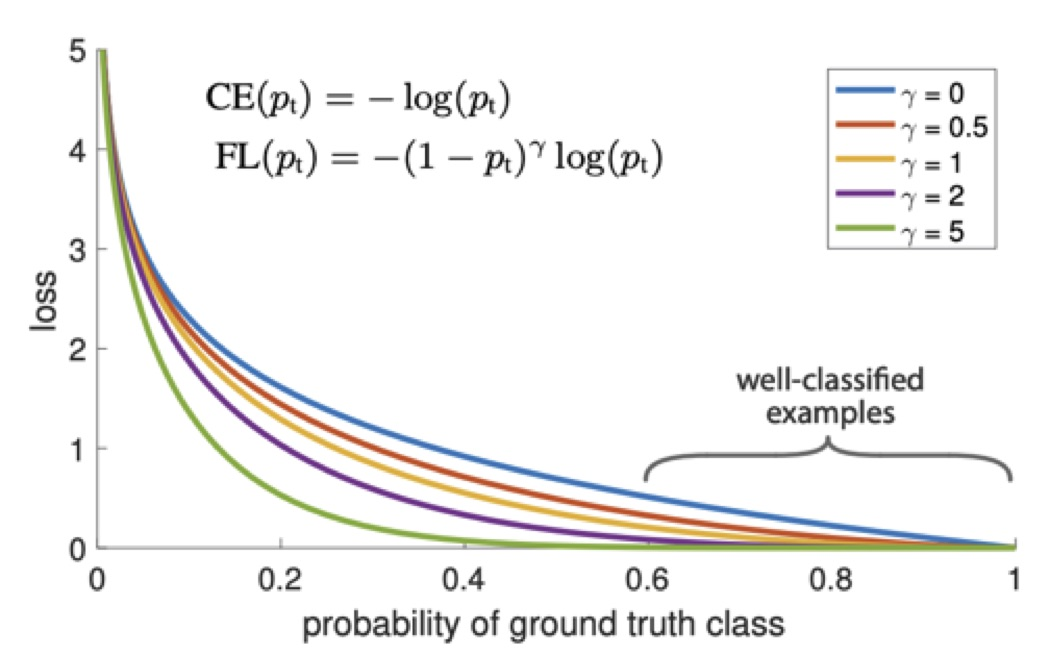

In [20]:
# p_t = y == 1 and p or y == -1 and 1 - p
# alpha_t = y == 1 and alpha or 1 - alpha 
Image(filename='images/focal loss.jpg')

In [21]:
# all together
anchors_res = anchors(img)
print (regression.shape, anchors_res.shape, annot.shape)
from retinanet.losses import FocalLoss # deepdive
focalLoss = FocalLoss(device=device)

# here for regression and classification
result = focalLoss(classification, regression, anchors_res, annot)
print ('loss', result)

8 (74880, 4)
16 (18720, 4)
32 (4680, 4)
64 (1170, 4)
128 (315, 4)
torch.Size([2, 99765, 4]) torch.Size([1, 99765, 4]) torch.Size([2, 40, 5])
loss (tensor([5893.6357], grad_fn=<MeanBackward1>), tensor([1.0218], grad_fn=<MeanBackward1>))


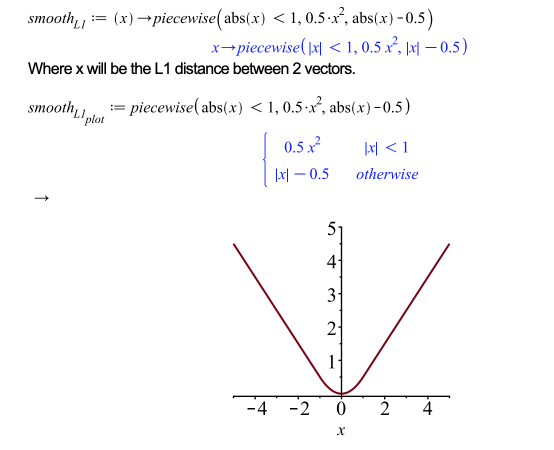

In [22]:
Image(filename='images/smooth-l1.png')


## Inference


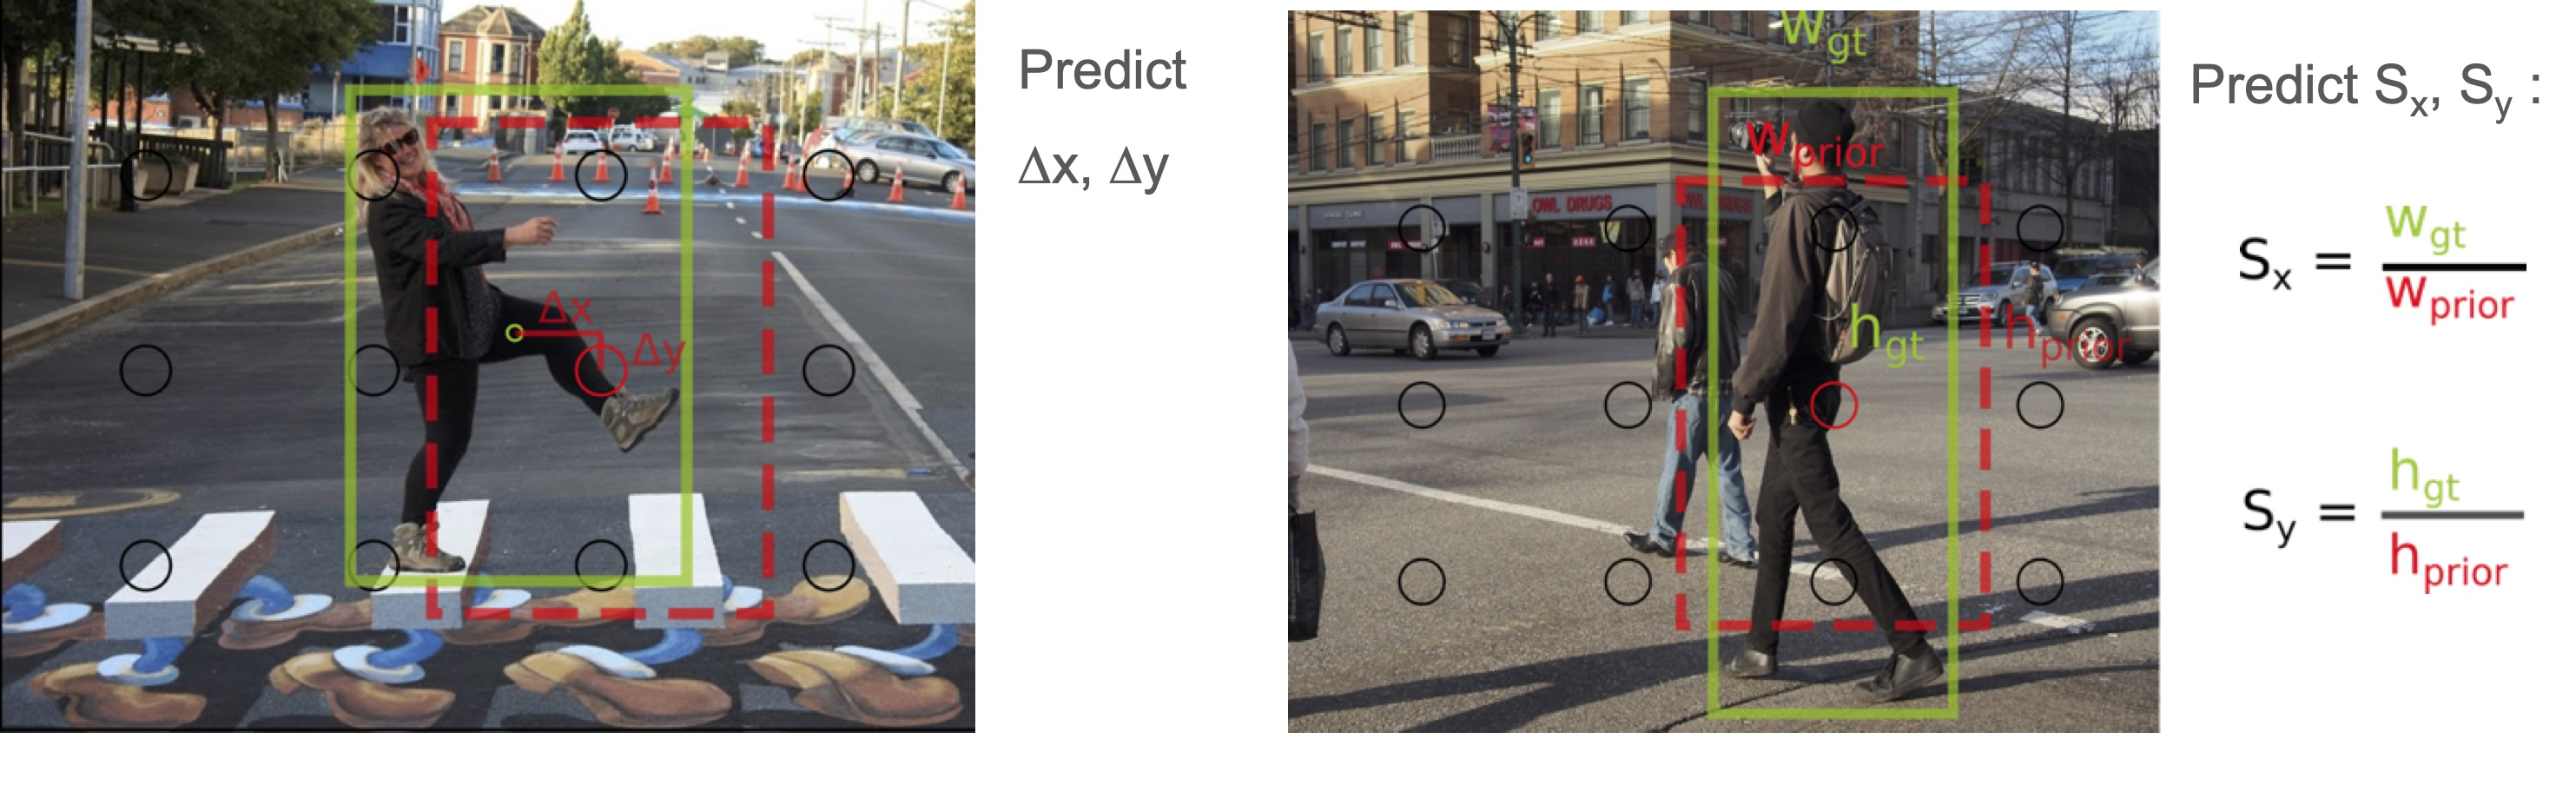

In [23]:
Image(filename='images/predictions.jpg')


In [24]:
# Inference
from torchvision.ops import nms
from retinanet.utils import BBoxTransform, ClipBoxes
regressBoxes = BBoxTransform(device=device)
clipBoxes = ClipBoxes()

transformed_anchors = regressBoxes(anchors_res, regression) # convert
transformed_anchors = clipBoxes(transformed_anchors, img) # clip

scores = torch.max(classification, dim=2, keepdim=True)[0]
print(scores.shape)

scores_over_thresh = (scores > 0.05)[0, :, 0] 

if scores_over_thresh.sum() == 0:
    # no boxes to NMS, just return
    print('result',[torch.zeros(0), torch.zeros(0), torch.zeros(0, 4)])
else:
    # NMS iteratively removes lower scoring boxes which have an
    #     IoU greater than iou_threshold with another (higher scoring) box
    classification = classification[:, scores_over_thresh, :]
    transformed_anchors = transformed_anchors[:, scores_over_thresh, :]
    scores = scores[:, scores_over_thresh, :]
    
    anchors_nms_idx = nms(transformed_anchors[0,:,:], scores[0,:,0], iou_threshold=0.5)
    
    nms_scores, nms_class = classification[0, anchors_nms_idx, :].max(dim=1)
    print('results', nms_scores.shape, nms_class.shape)


torch.Size([2, 99765, 1])
results torch.Size([9642]) torch.Size([9642])


In [25]:
from retinanet import model
retina_model = model.resnet18(num_classes=dataset_train.num_classes(), pretrained=True)
# retina_model.load_state_dict(torch.load('data/coco_resnet_50_map_0_335_state_dict.pt'))

device = torch.cuda.is_available() and 'cuda' or 'cpu'
retina_model = retina_model.to(device=device)
# 
# for param in retina_model.parameters():
#     param.requires_grad = False
# 

params = [p for p in retina_model.parameters() if p.requires_grad]
retina_model = torch.nn.DataParallel(retina_model).to(device=device)
     
print('Done')

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to .\resnet18-5c106cde.pth



Done


In [26]:
# prepare
import collections
import torch.optim as optim
dataset_val.image_ids = val_imgs[:100]  # TEST
# dataset_train.image_ids = train_imgs
retina_model.training = True

optimizer = optim.Adam(params, lr=1e-5)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

loss_hist = collections.deque(maxlen=500)

print('Num training images: {}'.format(len(dataset_train)))

Num training images: 118287


In [27]:
from retinanet import coco_eval

def routine(retina_model, scheduler):
    retina_model.train()
    retina_model.module.freeze_bn()

    epoch_loss = []

    for iter_num, data in enumerate(dataloader_train):
        try:
            optimizer.zero_grad()
            classification_loss, regression_loss = retina_model([data['img'].to(device).float(), data['annot']])
                
            classification_loss = classification_loss.mean()
            regression_loss = regression_loss.mean()

            loss = classification_loss + regression_loss

            if bool(loss == 0):
                continue

            loss.backward()

            torch.nn.utils.clip_grad_norm_(retina_model.parameters(), 0.1)

            optimizer.step()

            loss_hist.append(float(loss))

            epoch_loss.append(float(loss))
            if iter_num % 10 == 0:
                print(
                    'Epoch: {} | Iteration: {} | Classification loss: {:1.5f} | Regression loss: {:1.5f} | Running loss: {:1.5f}'.format(
                        epoch_num, iter_num, float(classification_loss), float(regression_loss), np.mean(loss_hist)))

            del classification_loss
            del regression_loss
        except Exception as e:
            print(e)
            continue
            
        # if iter_num > 1000:
        #     break


    print('Evaluating dataset')
    coco_eval.evaluate_coco(dataset_val, retina_model)
    
    scheduler.step(np.mean(epoch_loss)) # should be val loss
    torch.save(retina_model.module, 'dev_retinanet_{}.pt'.format(epoch_num))
        

In [ ]:
# routine
epochs = 10
for epoch_num in range(epochs):
    routine(retina_model, scheduler)

## Efficient det

Main difference from RetinaNet - EfficientNet as a Backbone + BiFPN

In [ ]:
Image(filename='images/bifpn.png')

